In [1]:
import os
import json
from datetime import datetime
from dotenv import load_dotenv
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_openai import OpenAIEmbeddings
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_community.vectorstores import FAISS
from langchain.document_loaders import TextLoader
import faiss

from langchain_community.docstore import InMemoryDocstore
from langchain_community.vectorstores import FAISS
import sys
import uuid
from psycopg_pool import ConnectionPool
from IPython.display import Image, display
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain.memory import VectorStoreRetrieverMemory
from langchain.agents.output_parsers import OpenAIFunctionsAgentOutputParser
from langchain.agents import AgentExecutor


# Set API keys
load_dotenv()
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
GROQ_API_KEY = os.getenv("GROQ_API_KEY")
LANGCHAIN_API_KEY = os.getenv("LANGCHAIN_API_KEY")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
COHERE_API_KEY = os.getenv("COHERE_API_KEY")

# Optionally, add tracing
os.environ["LANGCHAIN_TRACING_V2"] = 'true'
os.environ["LANGCHAIN_ENDPOINT"] = 'https://api.smith.langchain.com'
os.environ["LANGCHAIN_PROJECT"] = "llama3-tool-use-agent"


In [2]:
from langchain_openai import ChatOpenAI
from langchain_cohere import CohereEmbeddings

GPT3 = 'gpt-3.5-turbo'
GPT4 = "gpt-4o-mini"
COHERE = 'embed-english-light-v3.0'

embeddings = CohereEmbeddings(model=COHERE)
llm = ChatOpenAI(model=GPT3, temperature=0)


AttributeError: module 'openai' has no attribute 'OpenAI'

In [ ]:
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

In [ ]:
import faiss
import numpy as np
from ollama import embeddings

from sklearn.metrics.pairwise import cosine_similarity

from transformers import AutoTokenizer, AutoModelForCausalLM
import json
import uuid

# Initialize the tokenizer and model for summarization

class AssistantMemoryWithFAISS:
    def __init__(self, embedding_model="nomic-embed-text", embedding_dim=768, similarity_threshold=0.8):
        self.model_name = embedding_model
        self.embedding_dim = embedding_dim
        self.similarity_threshold = similarity_threshold
        self.index = faiss.IndexFlatL2(embedding_dim)
        self.texts = []
        self.metadata = []
        self.embedding_list = []

    def generate_embedding(self, text):
        try:
            response = embeddings(model=self.model_name, prompt=text)
            embedding = np.array(response['embedding']).reshape(1, -1)  # Reshape for FAISS
            if embedding.shape[1] != self.embedding_dim:
                raise ValueError(f"Embedding dimension mismatch: expected {self.embedding_dim}, got {embedding.shape[1]}")
            return embedding
        except Exception as e:
            print(f"Error generating embedding: {e}")
            return None

    def add_data(self, text, meta):
        embedding = self.generate_embedding(text)
        if embedding is not None:
            print(f"Generated embedding for text: {text}")  # Debugging: Print generated embedding
            self.texts.append(text)
            self.metadata.append(meta)  # Save the metadata related to the text
            self.embedding_list.append(embedding)  # Ensure this list is in sync with the FAISS index
            self.index.add(embedding)
            print(f"Saved context for text: '{text}' with metadata: {meta}")
            print(f"Current length of embedding_list: {len(self.embedding_list)}")  # Debugging: Print length after saving
            print(f"Current FAISS index size: {self.index.ntotal}")  # Debugging: Print FAISS index size

    def retrieve_data(self, query, top_k=20):
        query_embedding = self.generate_embedding(query)
        if query_embedding is not None:
            distances, indices = self.index.search(query_embedding, top_k)
            print(f"indices: {indices}")  # Debugging: Print indices
            print(f"length of embedding_list: {len(self.embedding_list)}")  # Debugging: Print length of embedding_list
            similar_texts = []
            for idx in indices[0]:
                if idx < len(self.embedding_list) and idx >= 0:  # Ensure idx is within the valid range
                    similarity = cosine_similarity(query_embedding, self.embedding_list[idx])[0][0]
                    if similarity >= self.similarity_threshold:
                        similar_texts.append((self.texts[idx], self.metadata[idx]))
            return similar_texts
        else:
            return []

    def delete_data(self, idx):
        del self.texts[idx]
        del self.metadata[idx]
        self.embedding_list.pop(idx)
        self.index.reset()
        for embedding in self.embedding_list:
            self.index.add(embedding)
        print(f"Deleted data at index: {idx}")
        
# Usage example
memory = AssistantMemoryWithFAISS()

In [ ]:
import requests

def fetch_weather_data(lat: float, lon: float) -> str:
    """Fetches weather data for a given latitude and longitude."""
    url = f"https://api.met.no/weatherapi/locationforecast/2.0/compact?lat={lat}&lon={lon}"
    headers = {
        "User-Agent": "MyTestApp/0.1"
    }
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        result = json.dumps(response.json(), indent=4)
        memory.add_data(f"Weather data fetched for coordinates ({lat}, {lon})", {"tool": "fetch_weather_data", "result": result})
        return result
    else:
        error_msg = f"Error fetching data: {response.status_code}"
        memory.add_data(f"Failed to fetch weather data for coordinates ({lat}, {lon})", {"tool": "fetch_weather_data", "result": error_msg})
        return error_msg

# Dictionary mapping region names to their corresponding price zones
price_zones = {
    "Oslo": "NO1",
    "Øst-Norge": "NO1",
    "Kristiansand": "NO2",
    "Sør-Norge": "NO2",
    "Trondheim": "NO3",
    "Midt-Norge": "NO3",
    "Tromsø": "NO4",
    "Nord-Norge": "NO4",
    "Bergen": "NO5",
    "Vest-Norge": "NO5"
}

def fetch_electricity_prices(year: str, month: str, day: str, region: str) -> str:
    """Fetches electricity prices for a given date and region."""
    # Determine the correct price zone for the given region
    price_zone = price_zones.get(region, None)
    
    if price_zone is None:
        error_msg = f"Unknown region: {region}. Please use one of the following regions: {', '.join(price_zones.keys())}."
        memory.add_data(f"Failed to fetch electricity prices for {year}-{month}-{day} in region {region}", {"tool": "fetch_electricity_prices", "result": error_msg})
        return error_msg

    url = f"https://www.hvakosterstrommen.no/api/v1/prices/{year}/{month}-{day}_{price_zone}.json"
    response = requests.get(url)
    
    if response.status_code == 200:
        result = json.dumps(response.json(), indent=4)
        memory.add_data(f"Electricity prices fetched for {year}-{month}-{day} in region {region}", {"tool": "fetch_electricity_prices", "result": result})
        return result
    else:
        error_msg = f"Error fetching data: {response.status_code}"
        memory.add_data(f"Failed to fetch electricity prices for {year}-{month}-{day} in region {region}", {"tool": "fetch_electricity_prices", "result": error_msg})
        return error_msg



def web_search(input: str) -> str:
    """Runs web search."""
    # Assuming TavilySearchResults is properly defined
    web_search_tool = TavilySearchResults()
    docs = web_search_tool.invoke({"query": input})
    memory.add_data(f"Web search performed for query '{input}'", {"tool": "web_search", "result": docs})
    return docs


@tool
def add_data_tool(text: str, meta: dict):
    """
    Use this tool to add data to the FAISS memory.
    """
    memory.add_data(text, meta)
    return "Data added successfully."

@tool
def retrieve_data_tool(query: str, top_k: int = 2):
    """
    Use this tool to extract data from the FAISS memory.
    """
    similar_texts = memory.retrieve_data(query, top_k)
    return similar_texts

@tool
def delete_data_tool(idx: int):
    """
    Use this tool to delete data from the FAISS memory.
    """
    return {"message": f"Are you sure you want to delete data at index {idx}?", "confirm": True, "index": idx}

@tool
def confirm_delete_tool(idx: int, confirm: bool):
    """
    Use this tool to confirm deletion of data from the FAISS memory.
    """
    if confirm:
        memory.delete_data(idx)
        return "Data deleted successfully."
    else:
        return "Deletion canceled."

custom_tools = [add_data_tool, retrieve_data_tool, delete_data_tool, confirm_delete_tool, fetch_weather_data, fetch_electricity_prices]

In [ ]:
primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        ("""
         ROLE:
         You are an helpful assistant who can interact with various data sources using specific tools to answer questions accurately.
         GOAL:
         Use the appropriate tool for the input question, retrieve data, and provide a relevant answer.
         INSTRUCTIONS:
         - Use tools only for their specified operations.
         - Construct your final answer using tool outputs.
         - For weather questions, use the weather data fetch tool.
         - For electricity price queries, use the electricity price fetch tool.
         - For database questions, follow FAISS instructions. Determine the appropriate tool based on the question, fetch the necessary data, and return the answer. "
         """
         "Current time: {time}."),
        ("placeholder", "{messages}")
    ]
).partial(time=datetime.now())

 - For real-time information, use the web search tool.

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import AnyMessage, add_messages

# Define the State type
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [ ]:
import openai

openai.api_key = OPENAI_API_KEY

In [ ]:
from langchain_core.runnables import RunnableLambda, RunnableConfig, Runnable

import transformers
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, pipeline
from functools import lru_cache
from typing import Callable, Dict, List, Optional, Tuple, Union

model_id = "gpt-4-mini"

# Define the Assistant class
class Assistant:
    def __init__(self, runnable: Callable, max_tokens=1000, model=model_id, summary_length=150, memory=None):
        self.runnable = runnable
        self.max_tokens = max_tokens
        self.summary_length = summary_length
        self.model = model
        self.memory = memory

    def truncate_message(self, message: str) -> str:
        tokens = openai.Completion.create(
            model=self.model,
            prompt=message,
            max_tokens=self.max_tokens,
            temperature=0
        )
        return tokens.choices[0].text.strip()

    def summarize_text(self, text: str, max_length=150) -> str:
        response = openai.Completion.create(
            model=self.model,
            prompt=f"Summarize the following text in {max_length} words: {text}",
            max_tokens=max_length,
            temperature=0.5
        )
        summary = response.choices[0].text.strip()
        return summary

    def __call__(self, state: Dict) -> Dict:
        while True:
            if state.get('messages'):
                last_message = state['messages'][-1]
                if isinstance(last_message, dict):
                    query_text = last_message.get('content')
                    if query_text and self.memory:
                        query_text = self.truncate_message(query_text)
                        print(f"Query text for memory retrieval: {query_text}")
                        similar_texts = self.memory.retrieve_data(query_text)
                        if similar_texts:
                            print("Found relevant memory:")
                            messages = []
                            for text, meta in similar_texts:
                                truncated_text = self.truncate_message(text)
                                messages.append({"role": "user", "content": truncated_text})
                            return {"messages": messages}

            result = self.runnable(state)

            # Summarize tool outputs if present
            if result.get('tool_calls'):
                for call in result['tool_calls']:
                    if 'result' in call and isinstance(call['result'], str):
                        call['result'] = self.summarize_text(call['result'], self.summary_length)
            
            if result.get('messages') and isinstance(result['messages'], list):
                if all(isinstance(msg, dict) for msg in result['messages']):
                    break

            messages = state.get("messages", []) + [{"role": "user", "content": "Respond with a real output."}]
            state = {**state, "messages": messages}

        # Summarize final output if too long
        if result.get('messages'):
            combined_text = ' '.join([msg['content'] for msg in result['messages'] if msg['role'] == 'assistant'])
            if len(combined_text.split()) > self.summary_length:
                summary = self.summarize_text(combined_text, self.summary_length)
                result['messages'] = [{"role": "assistant", "content": summary}]

        return {"messages": result.get('messages', [])}

# Tool
def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )

# Utilities
def _print_event(event: dict, _printed: set, max_length=1500) -> None:
    current_state = event.get("dialog_state")
    if current_state:
        print(f"Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if isinstance(message, dict) and message.get('id') not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message['id'])

def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1]['tool_calls']
    return {
        "messages": [
            {"role": "assistant", "content": f"Error: {repr(error)}\n please fix your mistakes.", "tool_call_id": tc["id"]}
            for tc in tool_calls
        ]
    }

# Initialize the runnable for the assistant
assistant_runnable = primary_assistant_prompt | llm.bind_tools(custom_tools)

# Initialize the assistant with memory
memory = AssistantMemoryWithFAISS()
assistant = Assistant(assistant_runnable, memory=memory)

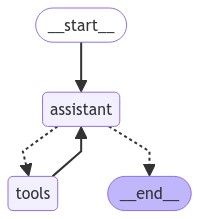

In [ ]:
from langgraph.graph.state import StateGraph, END
from langgraph.prebuilt import ToolNode, tools_condition

# Create the graph
builder = StateGraph(State)

# Add nodes
builder.add_node("assistant", RunnableLambda(assistant))
builder.add_node("tools", create_tool_node_with_fallback(custom_tools))

# Define edges
builder.set_entry_point("assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
    {"tools": "tools", END: END},
)
builder.add_edge("tools", "assistant")

# Compile the graph
graph = builder.compile()

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception as e:
    print(f"Failed to display graph: {e}")

In [ ]:
# Test saving context
memory.add_data("This is a test sentence.", {"tool": "test_tool", "result": "test_result"})
memory.add_data("Another example text.", {"tool": "test_tool", "result": "test_result"})

# Test retrieval
query_text = "This is a test sentence."
similar_texts = memory.retrieve_data(query_text)
print("Similar texts:", similar_texts)

Generated embedding for text: This is a test sentence.
Saved context for text: 'This is a test sentence.' with metadata: {'tool': 'test_tool', 'result': 'test_result'}
Current length of embedding_list: 1
Current FAISS index size: 1
Generated embedding for text: Another example text.
Saved context for text: 'Another example text.' with metadata: {'tool': 'test_tool', 'result': 'test_result'}
Current length of embedding_list: 2
Current FAISS index size: 2
indices: [[ 0  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]
length of embedding_list: 2
Similar texts: [('This is a test sentence.', {'tool': 'test_tool', 'result': 'test_result'})]


In [ ]:
# def manage_context_size(state: Dict, max_tokens: int, tokenizer: AutoTokenizer) -> Dict:
#     total_tokens = sum(len(tokenizer.encode(message['content'])) for message in state.get('messages', []))
#     while total_tokens > max_tokens:
#         state['messages'].pop(0)
#         total_tokens = sum(len(tokenizer.encode(message['content'])) for message in state.get('messages', []))
#     return state


In [ ]:
# Adding data to memory
memory.add_data("Hello, how can I help you today?", {"metadata_key": "metadata_value"})

# Example state
state = {
    "messages": [
        {"role": "user", "content": "Hello, how can I help you today?"}
    ]
}

# Running the assistant
response = assistant(state)
print(response)


Generated embedding for text: Hello, how can I help you today?
Saved context for text: 'Hello, how can I help you today?' with metadata: {'metadata_key': 'metadata_value'}
Current length of embedding_list: 3
Current FAISS index size: 3


APIRemovedInV1: 

You tried to access openai.Completion, but this is no longer supported in openai>=1.0.0 - see the README at https://github.com/openai/openai-python for the API.

You can run `openai migrate` to automatically upgrade your codebase to use the 1.0.0 interface. 

Alternatively, you can pin your installation to the old version, e.g. `pip install openai==0.28`

A detailed migration guide is available here: https://github.com/openai/openai-python/discussions/742


In [ ]:
questions = [
    "What is magic_function(3)",
    "What was the weather at Lillehammer yesterday?",
]

_printed = set()
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        "thread_id": thread_id,  # Checkpoints are accessed by thread_id
    }
}

events = graph.stream(
    {"messages": [("user", questions[1])]}, config, stream_mode="values"
)

for event in events:
    _print_event(event, _printed)

TypeError: 'RunnableSequence' object is not callable